In [1]:
from google.colab import drive
ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
from os.path import join  
import sys
MY_GOOGLE_DRIVE_PATH = 'My Drive/repos/govind_swyam'
PROJECT_NAME = 'catsetmat'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH, PROJECT_NAME)
%ls "$PROJECT_PATH/src"
sys.path.append(PROJECT_PATH)
from src.our_utils import mkdir_p

data_reader.py       main.py         __pycache__/
embedding_storer.py  our_modules.py  results_analyzer.py
__init__.py          our_utils.py    train_test_sampler.py
1.0 -0.5


In [3]:
import numpy as np
import pickle
import pandas as pd
from tqdm.autonotebook import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [0]:
data_name = 'so_users_tags'
data_path = join(PROJECT_PATH, 'data/original/', data_name)
raw_data_path = join(PROJECT_PATH, 'data/raw/', data_name)
mkdir_p(raw_data_path)
questions_file = 'questions.csv'
answers_file = 'answers.csv'
output_file = 'users.csv'
comments_files = ['comments1.csv', 'comments2.csv']
tags_file = 'tags.csv'

id_left_file_name = 'id_a_map.txt'
id_right_file_name = 'id_k_map.txt'
id_mid_file_name = 'id_p_map.txt'
mid_left_list_file_name = 'p_a_list_train.txt'
mid_right_list_file_name = 'p_k_list_train.txt'

In [5]:
try:
    users_tags_df = pickle.load(open(join(data_path, 'users_tags_df.pkl'), 'rb'))
except FileNotFoundError:
    print('Reading {}'.format(questions_file))
    ques_df = pd.read_csv(join(data_path, questions_file))
    try:
        print('Reading {}'.format(output_file))
        df = pd.read_csv(join(data_path, output_file))
        df['user_id'] = df['user_id'].apply(eval)
    except FileNotFoundError:
        print('{} not found! Preparing from scratch again.'.format(output_file))
        print('Reading {}'.format(answers_file))
        ans_df = pd.read_csv(join(data_path, answers_file))
        df = pd.concat(
        [ques_df[['id', 'owner_user_id']].replace({-1: np.nan}).rename(
            columns = {'id': 'ques_id', 'owner_user_id': 'user_id'}).fillna(-1).astype(int), # Question askers
        #  ques_df[ques_df['owner_user_id'] != ques_df['last_editor_user_id']]\
        #     [['id', 'last_editor_user_id']].replace({-1: np.nan}).dropna().rename(
        #         columns = {'id': 'ques_id', 'last_editor_user_id': 'user_id'}).astype(int), # Question editors
        ans_df[['parent_id', 'owner_user_id']].replace({-1: np.nan}).rename(
            columns = {'parent_id': 'ques_id', 'owner_user_id': 'user_id'}).fillna(-1).astype(int), # Answerers
        #  ans_df[ans_df['owner_user_id'] != ans_df['last_editor_user_id']]\
        #     [['parent_id', 'last_editor_user_id']].replace({-1: np.nan}).dropna().rename(
        #         columns = {'parent_id': 'ques_id', 'last_editor_user_id': 'user_id'}).fillna(-1).astype(int) # Answer editors
        ])
        print('Performing groupby...')
        df = df.groupby('ques_id').agg(set).apply({'user_id': lambda x: x.difference({-1})})
        df = df[df['user_id'].apply(lambda x: len(x) > 1)]
        df.to_csv(join(data_path, output_file))
    ques_df = ques_df[['id', 'creation_date', 'tags']]
    ques_df['tags'] = ques_df['tags'].fillna('').apply(lambda x: set(x.split('|')))
    ques_df = ques_df[ques_df['tags'].apply(lambda x: len(x) > 1)]
    print('Merging dataframes...')
    users_tags_df = df.merge(ques_df, how='inner', left_on='ques_id', right_on='id')\
        [['ques_id', 'user_id', 'tags', 'creation_date']].rename(
            columns = {'ques_id': 'ques', 'user_id': 'users',
                       'creation_date': 'date', 'tags': 'tags'})
    del df
    del ques_df
    pickle.dump(users_tags_df, open(join(data_path, 'users_tags_df.pkl'), 'wb'))

Reading questions.csv
Reading users.csv
Merging dataframes...


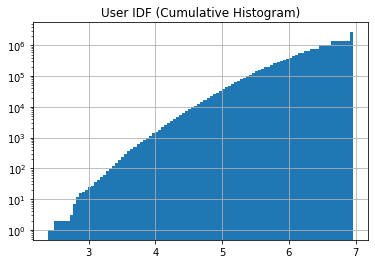

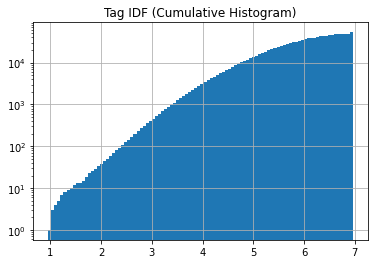

In [6]:
user_sets = list(users_tags_df['users'])
user_freq = defaultdict(int)
for user_set in tqdm(user_sets):
    for user in user_set:
        user_freq[user] += 1
user_freq
user_freq_df = pd.DataFrame({'freq': user_freq})
N = len(user_sets)
user_freq_df['idf'] = np.log10(N / user_freq_df['freq'])

tag_sets = list(users_tags_df['tags'])
tag_freq = defaultdict(int)
for tag_set in tqdm(tag_sets):
    for tag in tag_set:
        tag_freq[tag] += 1
tag_freq
tag_freq_df = pd.DataFrame({'freq': tag_freq})
N = len(tag_sets)
tag_freq_df['idf'] = np.log10(N / tag_freq_df['freq'])

fig, ax = plt.subplots()
user_freq_df['idf'].hist(cumulative=True, bins=100)
plt.yscale('log')
plt.title('User IDF (Cumulative Histogram)')
fig, ax = plt.subplots()
tag_freq_df['idf'].hist(cumulative=True, bins=100)
plt.yscale('log')
_ = plt.title('Tag IDF (Cumulative Histogram)')

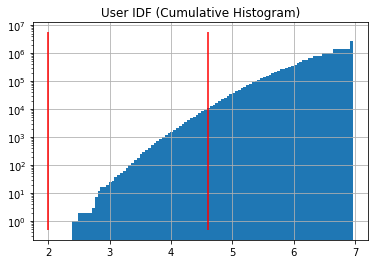

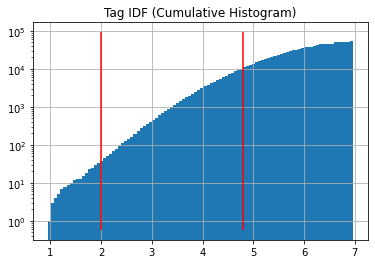

In [7]:
user_idf_range = (2, 4.6)
tag_idf_range = (2, 4.8)

fig, ax = plt.subplots()
user_freq_df['idf'].hist(cumulative=True, bins=100)
plt.yscale('log')
plt.title('User IDF (Cumulative Histogram)')
plt.vlines(user_idf_range, *ax.get_ylim(), 'r')

fig, ax = plt.subplots()
tag_freq_df['idf'].hist(cumulative=True, bins=100)
plt.yscale('log')
_ = plt.title('Tag IDF (Cumulative Histogram)')
plt.vlines(tag_idf_range, *ax.get_ylim(), 'r')

In [0]:
final_users = set(user_freq_df[(user_freq_df['idf'] >= user_idf_range[0]) & (user_freq_df['idf'] <= user_idf_range[1])].index)
final_tags = set(tag_freq_df[(tag_freq_df['idf'] >= tag_idf_range[0]) & (tag_freq_df['idf'] <= tag_idf_range[1])].index)

In [10]:
reduced_users_tags_df = users_tags_df[users_tags_df['users'].apply(lambda x: not x.isdisjoint(final_users)) & 
                                      users_tags_df['tags'].apply(lambda x: not x.isdisjoint(final_tags))].apply(
                                          {'ques': lambda x: x,
                                           'users': lambda x: x.intersection(final_users),
                                           'tags': lambda x: x.intersection(final_tags),
                                           'date': lambda x: x})
old_n = reduced_users_tags_df.shape[0]
users_size_range = (2, 25)
tags_size_range = (2, 25)
reduced_users_tags_df = reduced_users_tags_df[reduced_users_tags_df['users'].apply(lambda x: users_size_range[0] <= len(x) <= users_size_range[1]) &
                                              reduced_users_tags_df['tags'].apply(lambda x: tags_size_range[0] <= len(x) <= tags_size_range[1])]
new_n = reduced_users_tags_df.shape[0]
print('{} rows with #users and #tags out of range deleted.'.format(old_n - new_n))

3683791 rows with #users and #tags out of range deleted.


In [0]:
quess = list(sorted(reduced_users_tags_df['ques']))
users = list(sorted(final_users))
tags = list(sorted(final_tags))

id_user_map = {i: u for i, u in enumerate(users)}
user_id_map = {u: i for i, u in enumerate(users)}

id_tag_map = {i: t for i, t in enumerate(tags)}
tag_id_map = {t: i for i, t in enumerate(tags)}

id_ques_map = {i: q for i, q in enumerate(quess)}
ques_id_map = {q: i for i, q in enumerate(quess)}

In [0]:
reduced_users_tags_df['users'] = reduced_users_tags_df['users'].apply(lambda x: ','.join(map(str, sorted([user_id_map[u] for u in x]))))
reduced_users_tags_df['tags'] = reduced_users_tags_df['tags'].apply(lambda x: ','.join(map(str, sorted([tag_id_map[u] for u in x]))))
reduced_users_tags_df['ques'] = reduced_users_tags_df['ques'].apply(ques_id_map.get)

In [0]:
pd.DataFrame({'value': id_user_map}).to_csv(join(raw_data_path, id_left_file_name), header=False, sep='\t')
pd.DataFrame({'value': id_tag_map}).to_csv(join(raw_data_path, id_right_file_name), header=False, sep='\t')
pd.DataFrame({'value': id_ques_map}).to_csv(join(raw_data_path, id_mid_file_name), header=False, sep='\t')
reduced_users_tags_df[['ques', 'users']].to_csv(join(raw_data_path, mid_left_list_file_name), index=False, header=False, sep='\t')
reduced_users_tags_df[['ques', 'tags']].to_csv(join(raw_data_path, mid_right_list_file_name), index=False, header=False, sep='\t')